In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.covariance import LedoitWolf
from sklearn.utils.extmath import randomized_svd
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize
from itertools import product
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
GRID_PARAMS = {
    'svd_rank': [7, 14],
    'train_months': [20, 30],
    'test_months': [10, 20],
    'use_momentum': [True, False],
    'short_constraint': ['no_short']
}


MAX_POSITION_SIZE = 0.15
MIN_POSITION_SIZE = 0.01
MOMENTUM_LOOKBACK = 126
MOMENTUM_WEIGHT = 0.3
RISK_FREE_RATE = 0.04
TRANSACTION_COST_BPS = 10
RANDOM_STATE = 42
TOP_N_STOCKS = 150


def get_sp500_tickers():
    """Get S&P 500 ticker list with fallback."""
    try:
        tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
        tickers = [t.replace('.', '-') for t in tables[0]['Symbol'].tolist()]
        print(f"✓ Retrieved {len(tickers)} S&P 500 tickers")
        return tickers
    except:
        print("Using fallback ticker list...")
        return ['APD', 'AFL', 'MMM', 'ACN', 'ABBV', 'ARE', 'ALB', 'ALL', 'GOOGL', 'A',
            'AKAM', 'ABNB', 'AES', 'LNT', 'ALLE', 'AOS', 'AMD', 'ABT', 'ADBE', 'ALGN',
            'MO', 'AON', 'AMT', 'AEP', 'AMGN', 'AMCR', 'AME', 'GOOG', 'APH', 'AIG',
            'AXP', 'AMZN', 'ATO', 'ACGL', 'T', 'APTV', 'ADSK', 'AMP', 'AIZ', 'AWK',
            'AJG', 'ANET', 'AAPL', 'APO', 'ADM', 'APP', 'AMAT', 'ADI', 'APA', 'BALL',
            'XYZ', 'AXON', 'BRK-B', 'BLK', 'BA', 'BKR', 'BBY', 'ADP', 'TECH', 'BIIB',
            'BAC', 'BDX', 'BAX', 'AVY', 'AVB', 'BX', 'BKNG', 'AZO', 'BK', 'BR',
            'COF', 'BSX', 'BRO', 'BF-B', 'CAT', 'CCL', 'BG', 'AVGO', 'CBOE', 'CAH',
            'CHRW', 'CPB', 'CDNS', 'C', 'CMG', 'CTAS', 'CINF', 'CB', 'CVX', 'CF',
            'COR', 'CNC', 'CHTR', 'CHD', 'CLX', 'CNP', 'SCHW', 'CDW', 'CBRE', 'CI',
            'CRL', 'CSCO', 'CFG', 'CME', 'COIN', 'CTVA', 'GLW', 'STZ', 'COO', 'CTRA',
            'KO', 'COP', 'ED', 'COST', 'CMS', 'CSGP', 'CPAY', 'CL', 'CAG', 'CTSH',
            'CPRT', 'CEG', 'CMCSA', 'DRI', 'CSX', 'DAL', 'DDOG', 'FANG', 'DVN', 'DECK',
            'DHR', 'DVA', 'DXCM', 'DLTR', 'CCI', 'DG', 'DELL', 'DE', 'CVS', 'DLR',
            'CMI', 'CRWD', 'DAY', 'DPZ', 'D', 'EIX', 'EMR', 'ELV', 'DOV', 'DUK',
            'EW', 'DTE', 'DD', 'ETN', 'ECL', 'ETR', 'EA', 'EME', 'DHI', 'EPAM',
            'EMN', 'EOG', 'EBAY', 'DASH', 'DOW', 'FFIV', 'EQIX', 'EG', 'ERIE', 'FICO',
            'EXR', 'EQT', 'EXPE', 'EXC', 'EFX', 'FAST', 'EXPD', 'EXE', 'EQR', 'ES',
            'XOM', 'EVRG', 'ESS', 'EL', 'FDS', 'FTNT', 'F', 'FITB', 'IT', 'BEN',
            'FE', 'FCX', 'FI', 'FIS', 'FOX', 'GEHC', 'FRT', 'GRMN', 'GEN', 'GEV',
            'FDX', 'FSLR', 'FTV', 'GE', 'HAS', 'HPE', 'GPC', 'GD', 'DOC', 'HSIC',
            'GILD', 'HCA', 'GPN', 'FOXA', 'HAL', 'HLT', 'HSY', 'GS', 'HIG', 'GL',
            'GDDY', 'GM', 'GIS', 'GNRC', 'IBM', 'HST', 'INTC', 'HRL', 'ITW', 'INCY',
            'HUM', 'IDXX', 'HBAN', 'IR', 'HOLX', 'IBKR', 'HD', 'IEX', 'HPQ', 'HON',
            'HII', 'PODD', 'HWM', 'ICE', 'INVH', 'ISRG', 'J', 'JBHT', 'INTU', 'IVZ',
            'IP', 'IQV', 'JPM', 'IRM', 'JNJ', 'JBL', 'IFF', 'IPG', 'HUBB', 'JCI',
            'K', 'KLAC', 'KVUE', 'KMB', 'KR', 'LII', 'KEYS', 'LIN', 'KKR', 'LHX',
            'KHC', 'JKHY', 'LLY', 'KMI', 'LDOS', 'KIM', 'LRCX', 'LVS', 'KDP', 'LEN',
            'LH', 'KEY', 'LW', 'LOW', 'MAS', 'MTCH', 'LYV', 'MA', 'LYB', 'MPC',
            'L', 'MLM', 'MMC', 'LULU', 'MKC', 'MTB', 'MAR', 'LKQ', 'LMT', 'MHK',
            'MCD', 'MGM', 'MSFT', 'MTD', 'MNST', 'MDT', 'MDLZ', 'MU', 'TAP', 'MCHP',
            'MET', 'MRK', 'MPWR', 'MCO', 'MCK', 'MOH', 'META', 'MRNA', 'MAA', 'NFLX',
            'MOS', 'MSCI', 'NKE', 'NWSA', 'NEM', 'MSI', 'NWS', 'MS', 'NEE', 'NUE',
            'NSC', 'NTAP', 'NTRS', 'NCLH', 'NRG', 'NDAQ', 'NOC', 'NDSN', 'NI', 'PLTR',
            'NXPI', 'ON', 'PH', 'PCAR', 'ORCL', 'OTIS', 'NVDA', 'PKG', 'PYPL', 'PANW',
            'OKE', 'PSKY', 'OXY', 'ORLY', 'ODFL', 'PAYC', 'NVR', 'PAYX', 'OMC', 'PPL',
            'PEG', 'PGR', 'PNC', 'PFG', 'PCG', 'PRU', 'PFE', 'PG', 'PNR', 'PSX',
            'PNW', 'PSA', 'PEP', 'PTC', 'POOL', 'PPG', 'PLD', 'PM', 'PHM', 'ROST',
            'REG', 'RVTY', 'REGN', 'HOOD', 'RMD', 'QCOM', 'RL', 'DGX', 'RJF', 'ROP',
            'RSG', 'PWR', 'ROK', 'RCL', 'SPGI', 'O', 'RF', 'RTX', 'ROL', 'CRM',
            'SWK', 'LUV', 'SHW', 'SRE', 'STT', 'SJM', 'STX', 'SPG', 'SNA', 'SOLV',
            'SBAC', 'SW', 'STLD', 'STE', 'SO', 'SBUX', 'SLB', 'SWKS', 'NOW', 'TPL',
            'TMUS', 'TMO', 'SYF', 'TXT', 'TEL', 'TTWO', 'TXN', 'TJX', 'SNPS', 'TER',
            'TDY', 'TGT', 'TSLA', 'SMCI', 'TRGP', 'TROW', 'TPR', 'TDG', 'TT', 'TSN',
            'ULTA', 'TTD', 'TRV', 'TFC', 'TYL', 'UNH', 'USB', 'TRMB', 'URI', 'SYY',
            'UAL', 'TKO', 'TSCO', 'UPS', 'UDR', 'UNP', 'WBD', 'VLTO', 'DIS', 'VTRS',
            'VRTX', 'VTR', 'UBER', 'VRSN', 'VZ', 'VMC', 'WRB', 'WMT', 'VICI', 'VRSK',
            'V', 'VLO', 'GWW', 'UHS', 'WDC', 'WMB', 'WEC', 'WELL', 'WTW', 'ZBH'
        ]

def download_data(tickers, start_date='1980-01-01', end_date='2025-06-30'):
    print(f"Downloading {len(tickers)} stocks...")

    try:
        raw_data = yf.download(tickers, start=start_date, end=end_date,
                               progress=False, threads=True, group_by='column')
    except:
        return None

    if raw_data.empty:
        return None

    if isinstance(raw_data.columns, pd.MultiIndex):
        data = raw_data['Adj Close'] if 'Adj Close' in raw_data.columns.get_level_values(0) else raw_data['Close']
    else:
        data = raw_data[['Adj Close']] if 'Adj Close' in raw_data.columns else raw_data[['Close']]

    print("Original shape:", data.shape)
    print("Total NaNs:", data.isna().sum().sum())
    print(data.head())

    data = data.dropna(axis=1, thresh=int(0.80 * len(data)))

    data = data.bfill()
    data = data.ffill()
    data = data.dropna()

    print(f"Final data: {len(data.columns)} stocks, {len(data)} days")
    print(data.head())
    return data

def filter_liquid_stocks(data, top_n=150):
  """Keep only most liquid stocks based on data completeness and price stability."""
  returns = data.pct_change().dropna()
  avg_activity = returns.abs().mean()

  selected = avg_activity.nlargest(top_n).index
  return data[selected]


tickers = get_sp500_tickers()
data = download_data(tickers, start_date='2000-01-01', end_date='2025-06-30')

if data is None or data.empty:
    print("ERROR: No data available")

print(f"\nFiltering to top {TOP_N_STOCKS} most liquid stocks...")
data = filter_liquid_stocks(data, top_n=TOP_N_STOCKS)


Using fallback ticker list...
Original shape: (6410, 480)
Total NaNs: 370850
Ticker              A      AAPL  ABBV  ABNB       ABT      ACGL  ACN  \
Date                                                                   
2000-01-03  43.113312  0.839281   NaN   NaN  8.134051  1.215037  NaN   
2000-01-04  39.819931  0.768521   NaN   NaN  7.901655  1.208433  NaN   
2000-01-05  37.349907  0.779767   NaN   NaN  7.887126  1.320692  NaN   
2000-01-06  35.927765  0.712287   NaN   NaN  8.163107  1.307485  NaN   
2000-01-07  38.921741  0.746027   NaN   NaN  8.250256  1.380124  NaN   

Ticker           ADBE        ADI       ADM  ...       WDC       WEC      WELL  \
Date                                        ...                                 
2000-01-03  16.274668  27.639875  6.013763  ...  2.380149  4.116289  3.454512   
2000-01-04  14.909399  26.241589  5.951124  ...  2.833511  4.143283  3.440468   
2000-01-05  15.204173  26.624674  5.857159  ...  2.644609  4.332226  3.538768   
2000-01-06  1

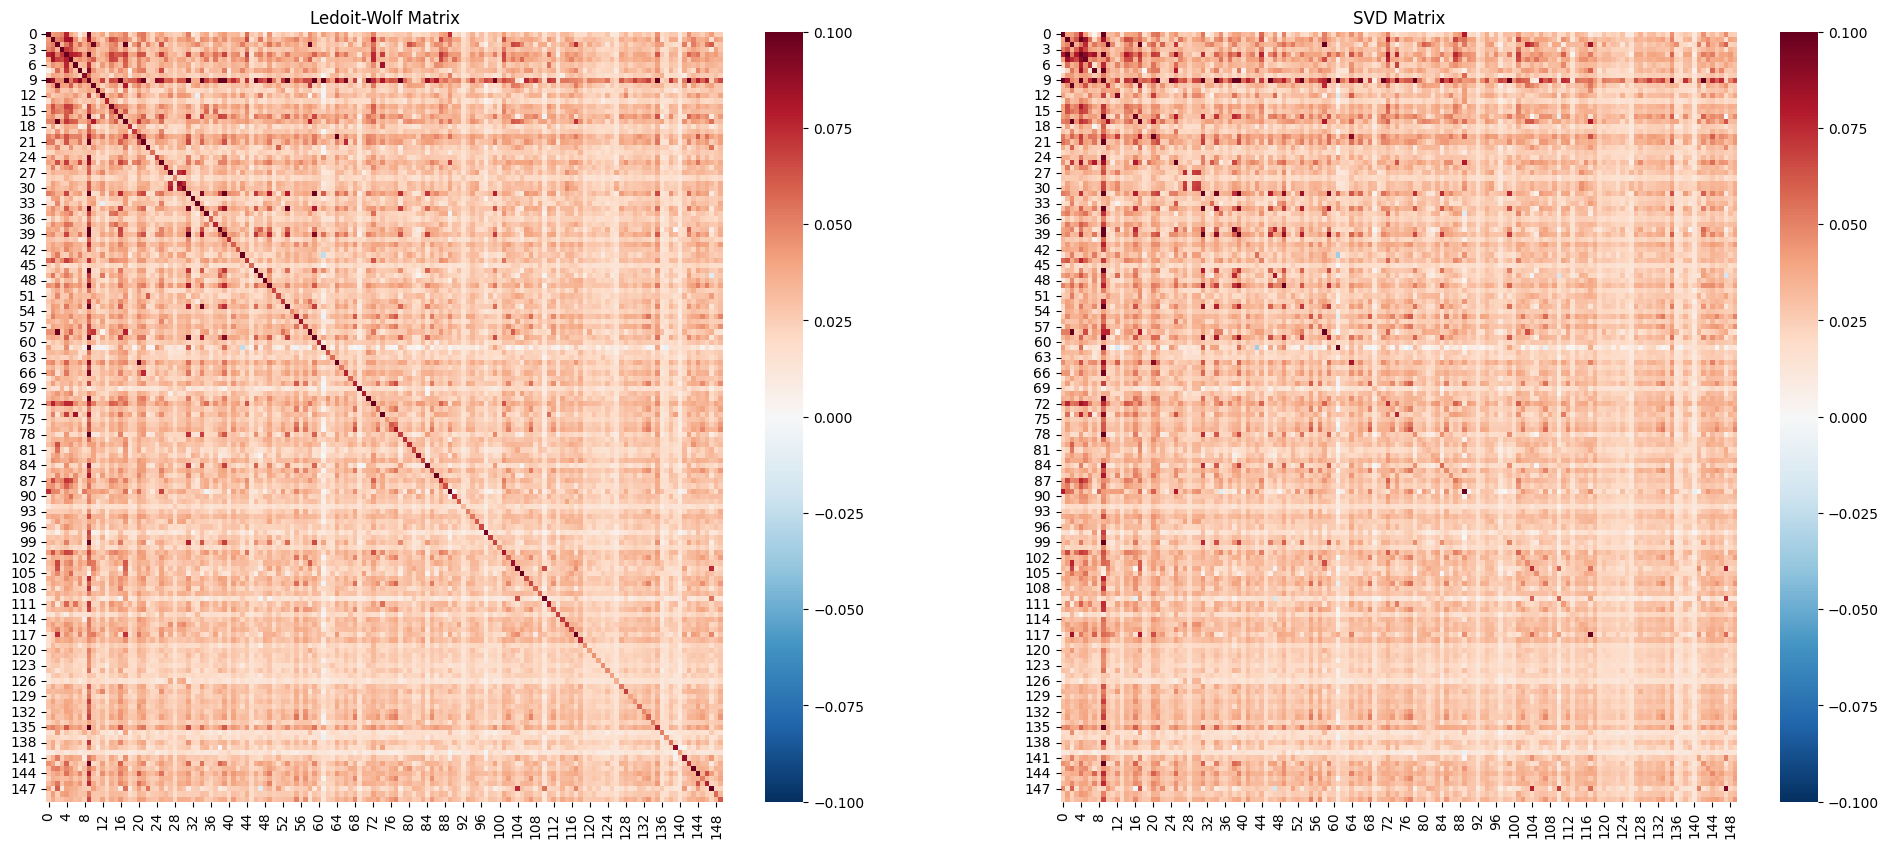

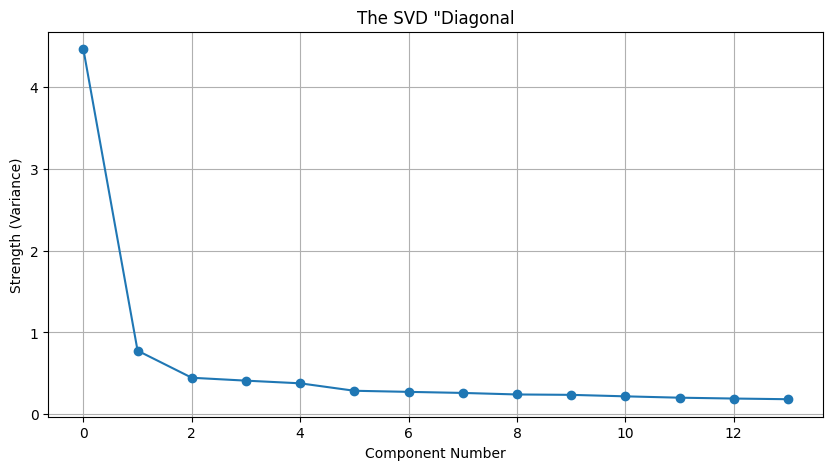

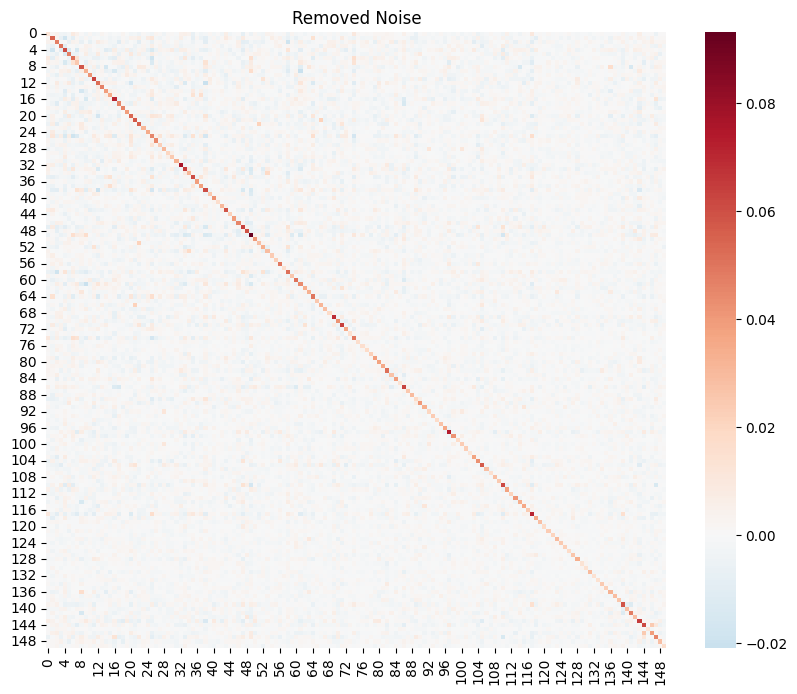

In [ ]:
subset = data.loc['2015-01-01':'2015-10-31']
rets = subset.pct_change().dropna()

lw = LedoitWolf()
lw.fit(rets)
cov_lw = lw.covariance_ * 252

U, s, Vt = randomized_svd(cov_lw, n_components=14, random_state=42)
cov_svd = U @ np.diag(s) @ Vt
cov_svd = (cov_svd + cov_svd.T) / 2

fig, ax = plt.subplots(1, 2, figsize=(24, 10))
sns.heatmap(cov_lw, ax=ax[0], cmap='RdBu_r', center=0, vmin=-0.1, vmax=0.1)
ax[0].set_title("Ledoit-Wolf Matrix")
sns.heatmap(cov_svd, ax=ax[1], cmap='RdBu_r', center=0, vmin=-0.1, vmax=0.1)
ax[1].set_title("SVD Matrix")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(s, 'o-')
plt.title('The SVD "Diagonal')
plt.ylabel('Strength (Variance)')
plt.xlabel('Component Number')
plt.grid(True)
plt.show()

noise = cov_lw - cov_svd
plt.figure(figsize=(10, 8))
sns.heatmap(noise, cmap='RdBu_r', center=0)
plt.title('Removed Noise')
plt.show()

In [ ]:

test_surv = yf.download(['LEHKQ', 'ENRN'], start='2000-01-01', end='2001-01-01', progress=False)


ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['LEHKQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2000-01-01 -> 2001-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 946702800, endDate = 978325200")')
ERROR:yfinance:['ENRN']: YFTzMissingError('possibly delisted; no timezone found')


In [ ]:
#Fonctions utilités

def calculate_momentum_scores(returns, lookback=126):
    """Calculate normalized momentum scores."""
    if len(returns) < lookback:
        return np.zeros(returns.shape[1])

    momentum_returns = returns.iloc[-lookback:].mean(axis=0)
    scores = (momentum_returns - momentum_returns.mean()) / (momentum_returns.std() + 1e-8)
    return scores.values


def get_bounds_from_constraint(n_assets, short_constraint, max_pos):
    """Return bounds tuple based on shorting constraint."""
    if short_constraint == 'no_short':
        return tuple((0, max_pos) for _ in range(n_assets))
    elif short_constraint == '10pct_short':
        return tuple((-0.10, max_pos) for _ in range(n_assets))
    else:
        return tuple((0, max_pos) for _ in range(n_assets))


def apply_portfolio_constraints(weights, bounds, min_pos=0.01):
    """Apply constraints and clean up weights."""
    weights = np.clip(weights, bounds[0][0], bounds[0][1])

    weights[np.abs(weights) < min_pos] = 0

    if np.sum(np.abs(weights)) < 1e-8:
        return np.ones(len(weights)) / len(weights)

    weights = weights / np.sum(weights)
    return weights


def maximum_sharpe_portfolio(expected_returns, cov_matrix, bounds, risk_free_rate=0.04):
    """Calculate maximum Sharpe ratio portfolio."""
    n_assets = cov_matrix.shape[0]
    cov_matrix_reg = cov_matrix + np.eye(n_assets) * 1e-8

    def negative_sharpe(w):
        ret = np.dot(w, expected_returns)
        std = np.sqrt(np.dot(w, np.dot(cov_matrix_reg, w)))
        return -(ret - risk_free_rate) / (std + 1e-10)

    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}]
    initial = np.ones(n_assets) / n_assets

    try:
        result = minimize(
            negative_sharpe,
            initial,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'maxiter': 1000, 'ftol': 1e-9}
        )

        weights = result.x if result.success else initial

    except Exception as e:
        print(f"    [WARN] Optimization failed: {e}")
        weights = initial

    return apply_portfolio_constraints(weights, bounds, MIN_POSITION_SIZE)


def calculate_max_drawdown(cumulative_returns):
    """Calculate maximum drawdown."""
    if len(cumulative_returns) == 0:
        return 0.0

    cumulative_returns = np.array(cumulative_returns)
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - running_max) / (running_max + 1e-10)
    return np.min(drawdown)

In [ ]:
# Calculs pour un backtest


def run_single_backtest(returns, params):
    svd_rank = params['svd_rank']
    train_months = params['train_months']
    test_months = params['test_months']
    use_momentum = params['use_momentum']
    short_constraint = params['short_constraint']

    try:
        total_days = len(returns)
        days_per_month = 21

        first_test_start = train_months * days_per_month
        remaining_days = total_days - first_test_start
        num_periods = int(remaining_days / (test_months * days_per_month))

        if num_periods < 1:
            return None

        period_returns = []
        cumulative_returns = [1.0]
        prev_weights = None

        for period_idx in range(num_periods):
            test_start_idx = first_test_start + (period_idx * test_months * days_per_month)
            test_end_idx = test_start_idx + test_months * days_per_month

            train_end_idx = test_start_idx
            train_start_idx = max(0, train_end_idx - train_months * days_per_month)

            if test_end_idx > len(returns):
                break

            train_returns = returns.iloc[train_start_idx:train_end_idx]
            test_returns = returns.iloc[test_start_idx:test_end_idx]

            if len(train_returns) < 100 or len(test_returns) < 10:
                continue

            train_data = train_returns.values
            n_assets = train_data.shape[1]

            expected_returns = train_data.mean(axis=0) * 252

            if use_momentum:
                momentum_scores = calculate_momentum_scores(train_returns, MOMENTUM_LOOKBACK)
                expected_returns = (1 - MOMENTUM_WEIGHT) * expected_returns + \
                                   MOMENTUM_WEIGHT * momentum_scores

            lw = LedoitWolf()
            lw.fit(train_data)
            cov_lw = lw.covariance_ * 252

            U, s, Vt = randomized_svd(cov_lw,
                                      n_components=min(svd_rank, n_assets - 1),
                                      random_state=RANDOM_STATE)
            cov_svd = U @ np.diag(s) @ Vt


            cov_svd = (cov_svd + cov_svd.T) / 2
            min_eig = np.min(np.linalg.eigvalsh(cov_svd))
            if min_eig < 1e-8:
                cov_svd += np.eye(n_assets) * (1e-6 - min_eig)

            bounds = get_bounds_from_constraint(n_assets, short_constraint, MAX_POSITION_SIZE)

            weights = maximum_sharpe_portfolio(expected_returns, cov_svd, bounds, RISK_FREE_RATE)

            if prev_weights is not None:
                turnover = np.sum(np.abs(weights - prev_weights))
            else:
                turnover = np.sum(np.abs(weights))

            cost = turnover * (TRANSACTION_COST_BPS / 10000)
            prev_weights = weights.copy()

            test_data = test_returns.values
            portfolio_rets = test_data @ weights
            portfolio_rets = portfolio_rets[np.isfinite(portfolio_rets)]
            portfolio_rets = np.clip(portfolio_rets, -0.5, 0.5)

            if len(portfolio_rets) > 0:
                period_return = (1 + portfolio_rets).prod() - 1 - cost
                period_returns.append(period_return)
                cumulative_returns.append(cumulative_returns[-1] * (1 + period_return))

        if len(period_returns) == 0:
            return None

        num_periods_completed = len(period_returns)
        actual_months_elapsed = num_periods_completed * test_months

        total_return = np.prod([1 + r for r in period_returns]) - 1
        annualized_return = (1 + total_return) ** (12 / actual_months_elapsed) - 1

        period_vol = np.std(period_returns)
        annualized_vol = period_vol * np.sqrt(12 / test_months)

        sharpe = (annualized_return - RISK_FREE_RATE) / (annualized_vol + 1e-10)
        max_dd = calculate_max_drawdown(cumulative_returns)

        return {
            'sharpe': sharpe,
            'return': annualized_return,
            'volatility': annualized_vol,
            'max_drawdown': max_dd,
            'num_periods': num_periods_completed,
            'total_months': actual_months_elapsed
        }

    except Exception as e:
        print(f"    ERROR: {e}")
        return None


In [ ]:
# Test tous nos parametres

def run_grid_search(returns):
    """Run grid search over all parameter combinations."""
    print("\n" + "=" * 80)
    print("STARTING GRID SEARCH WITH SVD - FIXED VERSION")
    print("=" * 80)

    param_names = list(GRID_PARAMS.keys())
    param_values = list(GRID_PARAMS.values())
    all_combinations = list(product(*param_values))

    print(f"Testing {len(all_combinations)} parameter combinations...\n")

    results = []

    for idx, combo in enumerate(all_combinations, 1):
        params = dict(zip(param_names, combo))

        print(f"[{idx}/{len(all_combinations)}] Testing: SVD={params['svd_rank']}, "
              f"Train={params['train_months']}m, Test={params['test_months']}m, "
              f"Momentum={params['use_momentum']}, Short={params['short_constraint']}")

        metrics = run_single_backtest(returns, params)

        if metrics is not None:
            result = {**params, **metrics}
            results.append(result)

            print(f"    ✓ Sharpe={metrics['sharpe']:.3f}, "
                  f"Return={metrics['return']*100:.2f}%, "
                  f"Vol={metrics['volatility']*100:.2f}%, "
                  f"MaxDD={metrics['max_drawdown']*100:.2f}%, "
                  f"Periods={metrics['num_periods']}")
        else:
            print(f"    ✗ Failed (insufficient data)")

        print()

    return pd.DataFrame(results)


In [ ]:
def main():

    returns = data.pct_change().dropna()
    print(f"Universe: {len(returns.columns)} stocks, {len(returns)} trading days")
    print(f"Date range: {returns.index[0].date()} to {returns.index[-1].date()}")

    results_df = run_grid_search(returns)

    if results_df.empty:
        print("ERROR: No successful backtests")
        return

    results_df = results_df.sort_values('sharpe', ascending=False)

    print("\n" + "=" * 80)
    print("GRID SEARCH RESULTS - TOP 10 CONFIGURATIONS")
    print("=" * 80)

    display_df = results_df.head(10).copy()
    display_df['return'] = display_df['return'] * 100
    display_df['volatility'] = display_df['volatility'] * 100
    display_df['max_drawdown'] = display_df['max_drawdown'] * 100

    display_df = display_df.rename(columns={
        'svd_rank': 'SVD',
        'train_months': 'Train(m)',
        'test_months': 'Test(m)',
        'use_momentum': 'Mom',
        'short_constraint': 'Short',
        'sharpe': 'Sharpe',
        'return': 'Ret%',
        'volatility': 'Vol%',
        'max_drawdown': 'MaxDD%',
        'num_periods': 'Per',
        'total_months': 'Months'
    })

    print(display_df.to_string(index=False))

    best = results_df.iloc[0]
    print("\n" + "=" * 80)
    print("BEST CONFIGURATION")
    print("=" * 80)
    print(f"SVD Rank: {best['svd_rank']}")
    print(f"Training Window: {best['train_months']} months")
    print(f"Testing Window: {best['test_months']} months")
    print(f"Momentum: {best['use_momentum']}")
    print(f"Short Constraint: {best['short_constraint']}")
    print(f"\nBacktest Period: {best['total_months']:.0f} months ({best['num_periods']} periods)")
    print(f"Sharpe Ratio: {best['sharpe']:.3f}")
    print(f"Annualized Return: {best['return']*100:.2f}%")
    print(f"Annualized Volatility: {best['volatility']*100:.2f}%")
    print(f"Maximum Drawdown: {best['max_drawdown']*100:.2f}%")
    print("=" * 80)

    results_df.to_csv('grid_search_results_fixed.csv', index=False)
    print("\n✓ Results saved to 'grid_search_results_fixed.csv'")

if __name__ == '__main__':
    main()

Universe: 150 stocks, 6409 trading days
Date range: 2000-01-04 to 2025-06-27

STARTING GRID SEARCH WITH SVD - FIXED VERSION
Testing 16 parameter combinations...

[1/16] Testing: SVD=7, Train=20m, Test=10m, Momentum=True, Short=no_short
    ✓ Sharpe=0.600, Return=23.20%, Vol=32.02%, MaxDD=-49.65%, Periods=28

[2/16] Testing: SVD=7, Train=20m, Test=10m, Momentum=False, Short=no_short
    ✓ Sharpe=0.620, Return=20.49%, Vol=26.60%, MaxDD=-43.75%, Periods=28

[3/16] Testing: SVD=7, Train=20m, Test=20m, Momentum=True, Short=no_short
    ✓ Sharpe=0.490, Return=24.09%, Vol=40.99%, MaxDD=-4.60%, Periods=14

[4/16] Testing: SVD=7, Train=20m, Test=20m, Momentum=False, Short=no_short
    ✓ Sharpe=0.581, Return=21.22%, Vol=29.64%, MaxDD=-11.15%, Periods=14

[5/16] Testing: SVD=7, Train=30m, Test=10m, Momentum=True, Short=no_short
    ✓ Sharpe=0.715, Return=27.75%, Vol=33.23%, MaxDD=-46.50%, Periods=27

[6/16] Testing: SVD=7, Train=30m, Test=10m, Momentum=False, Short=no_short
    ✓ Sharpe=0.594, Re